[OK] Saved CSV → level1_sma_crossover.csv
[OK] Saved Summary → level1_sma_summary.json
CAGR: 0.989%, Sharpe: 0.14


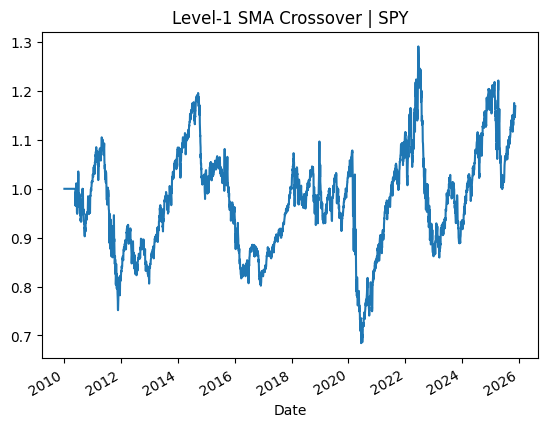

In [1]:
# level1_sma_crossover.py
# Simple Moving Average Crossover Engine (Level-1)
# Free data (yfinance), TC-aware, notebook-safe CLI

import json
import argparse
import numpy as np
import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict


# ------------------ CONFIG ------------------
@dataclass
class Config:
    symbol: str = "SPY"
    short: int = 20
    long: int = 100
    tc_bps: float = 10     # round-trip cost in basis points
    start: str = "2010-01-01"
    out_csv: str = "level1_sma_crossover.csv"
    out_json: str = "level1_sma_summary.json"


# ------------------ DATA ------------------
def load_data(cfg: Config):
    df = yf.download(cfg.symbol, start=cfg.start, auto_adjust=True, progress=False)
    if df.empty:
        raise RuntimeError("Error loading data.")
    df = df[["Close"]].rename(columns={"Close": "close"})
    return df


# ------------------ SIGNAL ENGINE ------------------
def compute_signals(df: pd.DataFrame, cfg: Config):
    df = df.copy()
    df["sma_s"] = df["close"].rolling(cfg.short).mean()
    df["sma_l"] = df["close"].rolling(cfg.long).mean()
    df["signal"] = np.where(df["sma_s"] > df["sma_l"], 1,
                    np.where(df["sma_s"] < df["sma_l"], -1, 0))
    df["signal"] = df["signal"].ffill().fillna(0)
    return df


# ------------------ BACKTEST ------------------
def backtest(df: pd.DataFrame, cfg: Config):
    df = df.copy()
    df["ret"] = df["close"].pct_change().fillna(0)

    # transaction cost: apply when signal flips
    df["flip"] = df["signal"].diff().abs()
    df["tc"] = df["flip"] * (cfg.tc_bps * 1e-4)

    df["strategy_ret"] = df["signal"].shift(1) * df["ret"] - df["tc"]

    df["equity"] = (1 + df["strategy_ret"]).cumprod()
    return df


# ------------------ REPORTING ------------------
def save_outputs(df: pd.DataFrame, cfg: Config):
    df.to_csv(cfg.out_csv)

    final_equity = float(df["equity"].iloc[-1])
    cagr = (final_equity ** (252 / len(df))) - 1
    sharpe = np.sqrt(252) * df["strategy_ret"].mean() / df["strategy_ret"].std()

    summary = {
        "symbol": cfg.symbol,
        "short_window": cfg.short,
        "long_window": cfg.long,
        "tc_bps": cfg.tc_bps,
        "final_equity": final_equity,
        "cagr": cagr,
        "sharpe": sharpe,
    }

    with open(cfg.out_json, "w") as f:
        json.dump(summary, f, indent=2)

    print(f"[OK] Saved CSV → {cfg.out_csv}")
    print(f"[OK] Saved Summary → {cfg.out_json}")
    print(f"CAGR: {cagr:.3%}, Sharpe: {sharpe:.2f}")


# ------------------ CLI ------------------
def parse_args() -> Config:
    p = argparse.ArgumentParser()
    p.add_argument("--symbol", type=str, default="SPY")
    p.add_argument("--short", type=int, default=20)
    p.add_argument("--long", type=int, default=100)
    p.add_argument("--tc-bps", type=float, default=10)
    p.add_argument("--start", type=str, default="2010-01-01")
    p.add_argument("--csv", type=str, default="level1_sma_crossover.csv")
    p.add_argument("--json", type=str, default="level1_sma_summary.json")

    a = p.parse_args()

    return Config(
        symbol=a.symbol,
        short=a.short,
        long=a.long,
        tc_bps=a.tc_bps,
        start=a.start,
        out_csv=a.csv,
        out_json=a.json
    )


# ------------------ MAIN ------------------
def main():
    cfg = parse_args()
    df = load_data(cfg)
    df = compute_signals(df, cfg)
    df = backtest(df, cfg)
    save_outputs(df, cfg)

    # Plot
    df["equity"].plot(title=f"Level-1 SMA Crossover | {cfg.symbol}")
    plt.show()


if __name__ == "__main__":
    # Jupyter shim
    import sys
    sys.argv = [sys.argv[0]] + [
        arg for arg in sys.argv[1:]
        if arg != "-f" and not (arg.endswith(".json") and "kernel" in arg)
    ]
    main()
